### Curve Shortening Flow
The aim of this notebook is to demonstrate the curve shortening flow for 1 dimensional graphs, and perhaps for planar curves. 

A javascript version of such an approximation partly inspired me to try implement such an approximation in Python, this can be found at https://github.com/acarapetis/curve-shortening-demo

The curve shortening flow is the 1-dimensional version of mean curvature flow. It is the evolution of a curve in the direction of it's curvature vector. In detail, let $\gamma : [0,1] \rightarrow \mathbb{R}^2$ be a curve (typically at least Lipschitz continuous). Writing $\gamma(t) = (x(t), y(t))$ we can write the (signed) curvature as the following local expression.

$$ \kappa = \frac{x' y'' - y' x''}{(x' ^2 + y' ^2)^\frac{3}{2}}$$

The curvature vector is then $\kappa \mathbf{n}$ where $\mathbf{n}$ is the normal vector. In $\mathbb{R}^2$ we have the following simple formula

$$ \mathbf{n} = \frac{1}{(x' ^2 + y' ^2)^\frac{1}{2}}(-y', x') $$

As such the curve shortening flow is a solution to the following partial differential equation, where $\gamma : [0,1] \times [0, T) \rightarrow \mathbb{R}^2$ is now a family of curves $\gamma(t,s) = \gamma_s (t)$.

$$ \frac{\partial \gamma_s}{\partial s} = \kappa_s \mathbf{n}_s. $$

### Coding details

A simple way to represent a continuous map on a computer is by sampling and linear approximation. Suppose we want a curve $\gamma:[0,2\pi] \rightarrow \mathbb{R}^2$. Then we create a grid in parameter space

$$ 0 = t_0 < t_1 < \ldots < t_{N-1} = 2\pi $$

In numpy one can use t = np.linspace(0,2*np.pi, N) to achieve this.

Then one samples $\gamma$ by evaluating $\gamma(t_i)$. 

Derivatives are then approximated by finite differences with respect to the parameter grid.

In the case of a closed curve, $\gamma(2\pi) = \gamma(0)$ we have to be particular careful about approximating $\gamma'(t)$ for $t$ near to $0$ or $2\pi$. 

As this is only an approximation, it can eventually break down, and indeed the approximation below behaves poorly once the curvatures start to get too large.

In [1]:
### imports ###
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

In [2]:
### Helper Methods ###

# Gradient of closed/periodic curve with respect to parameter
def grad(x,t, period = 2*np.pi):
    dx = (np.roll(x,-1)-np.roll(x,1))/((np.roll(t,-1)-np.roll(t,1))%period)
    dx[0] = (x[1]-x[-2])/((t[1]-t[-2])%period)
    dx[-1] = dx[0]
    return dx

# A moving average smoothing method.
def moving_average_smooth(x, window_size):
    for i in range(len(x)):
        smoothed = x[i]
        for j in range(window_size):
            smoothed += x[i-j]
            smoothed += x[(i+j)%len(x)]
        x[i] = smoothed/(2*window_size + 1)

# Simple vector norm in 2D
def norm(x,y):
    return np.sqrt(np.power(x,2)+np.power(y,2))

In [3]:
def test_norm_345():
    assert norm(3,4)==5

def test_norm_shape(shape):
    x = np.ones(shape)
    y = np.ones(shape)
    assert norm(x,y).shape==x.shape
    
test_norm_345()
test_norm_shape(10)
test_norm_shape((2,2))
test_norm_shape((0,0,0))

In [4]:
def test_grad_x():
    t = np.linspace(0,1,10)
    x = t
    # Only check interior values as this is not a periodic function
    assert np.sum(np.power(grad(x,t,period=2)[1:-1] - np.ones(8),2))==0
    
def test_grad_cos(tol = 0.001):
    t = np.linspace(0,2*np.pi,50)
    x = np.cos(t)
    assert np.sum(np.power(grad(x,t,period = 2*np.pi)+np.sin(t),2))<tol
    
test_grad_x()
test_grad_cos(tol=0.001)

In [5]:
### Curve class ###

class Curve:

    # Constructor
    def __init__(self,t,fx,fy):
        self.t = t
        self.x = fx(self.t)
        self.y = fy(self.t)


    # Plot method
    def plot(self):
        plt.plot(self.x, self.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Plot of the curve")
        plt.show()

    # Vector norm of parameters
    def dr(self):
        return norm(self.x, self.y)

    # Approximate the Tangent vector field
    def tangent(self):
        dx = grad(self.x,self.t)
        dy = grad(self.y,self.t)
        normalisation = norm(dx, dy)
        tx = dx/normalisation
        ty = dy/normalisation
        return tx,ty

    # Plot the tangent vector field
    def tangent_plot(self):
        tx,ty = self.tangent()
        #plt.plot(self.x,self.y) # This is a little redundant, except for checking.
        plt.quiver(self.x,self.y,tx,ty)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Plot of the tangent vector field")
        plt.show()

    # Approximate the normal vector field
    def normal(self):
        tx, ty = self.tangent()
        return -ty, tx

    # Plot the normal vector field
    def normal_plot(self):
        nx,ny = self.normal()
        plt.plot(self.x,self.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.quiver(self.x,self.y,nx,ny)
        plt.title("Plot of the normal vector field")
        plt.show()

    # Approxiamte curvature
    def curvature(self):
        dx = grad(self.x, self.t)
        ddx = grad(dx, self.t)
        dy = grad(self.y, self.t)
        ddy = grad(dy, self.t)
        k = (dx*ddy - ddx*dy)/(np.power(norm(dx,dy),3))
        return k

    # Plot the curvature vector field
    def curvature_plot(self):
        nx,ny = self.normal()
        k = self.curvature()
        plt.plot(self.x,self.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.quiver(self.x,self.y, nx*k, ny*k)
        plt.title("Plot of the curvature vector field")
        plt.show()

    # Approximate the curvature flow for a unit of time.
    # Note that this updates the current curve rather than instantiating a new curve.
    # Good for memory, but you lose the current curve.
    def evolve(self, step_size=1, smoothing = True, window_size = 2):
        nx,ny = self.normal()
        k = self.curvature()
        x = self.x + step_size*nx*k
        y = self.y + step_size*ny*k

        if(smoothing):
            moving_average_smooth(x,window_size)
            moving_average_smooth(y,window_size)
        self.x = x
        self.y = y
    
    # Method to animate the evolution
    # Note - making step size shrink with the iterations may help stability
    # The idea is that after many iterations, the curve is shrunk quite small
    # As such it has high curvatures, so too larger step size will over shoot.
    def animate_evolution(self,iterations, step_size, smoothing=True, window_size=1):
        xs = []
        ys = []
        xmin = np.min(self.x)
        xmax = np.max(self.x)
        ymin = np.min(self.y)
        ymax = np.max(self.y)
        for i in range(iterations):
            xs.append(self.x)
            ys.append(self.y)
            self.evolve(step_size = step_size, smoothing=smoothing, window_size=window_size)
        fig,ax = plt.subplots()
        ax.set_xlim((xmin-0.1, xmax+0.1))
        ax.set_ylim((ymin-0.1, ymax+0.1))
        plt.gca().set_aspect('equal', adjustable='box')
        line, = ax.plot([],[],lw = 2)
    
        def init():
            line.set_data([],[])
            return (line,)
    
        def animate(i):
            line.set_data(xs[i],ys[i])
            return (line,)
        anim = animation.FuncAnimation(fig, animate, init_func = init, frames = iterations, interval = 100, blit = True)
        return anim

In [6]:
def test_tangent_circle_is_unit(tol = 0.000001):
    t = np.linspace(0,2*np.pi, 50)
    circle = Curve(t,np.cos,np.sin)
    tx,ty = circle.tangent()
    assert np.sum(np.power(norm(tx,ty)-np.ones(tx.shape),2))<tol

def test_tangent_circle_is_tangent(tol = 0.001):
    t = np.linspace(0,2*np.pi,50)
    circle = Curve(t,np.cos, np.sin)
    tx,ty = circle.tangent()
    Tx = -np.sin(t)
    Ty = np.cos(t)
    assert np.sum(np.power(tx-Tx,2))+np.sum(np.power(ty-Ty,2))<tol
    
def test_tangent_ellipse_is_tangent(tol = 0.001):
    t = np.linspace(0,2*np.pi,50)
    circle = Curve(t,lambda t : 2*np.cos(t), np.sin)
    tx,ty = circle.tangent()
    Tx = -2*np.sin(t)
    Ty = np.cos(t)
    normalisation = norm(Tx,Ty)
    Tx = Tx/normalisation
    Ty = Ty/normalisation
    assert np.sum(np.power(tx-Tx,2))+np.sum(np.power(ty-Ty,2))<tol
    
def test_curvature_circle(r=1,tol=1e-5):
    t = np.linspace(0,2*np.pi, 50)
    circle = Curve(t, lambda t : r*np.cos(t), lambda t : r*np.sin(t))
    assert np.sum(np.power(circle.curvature() - np.ones(t.shape)/r,2))<tol
    
    
test_tangent_circle_is_unit(1e-10)
test_tangent_circle_is_tangent(1e-10)
test_tangent_ellipse_is_tangent(1e-10)
test_curvature_circle(np.pi, 1e-10)

In [7]:
# A circle evolves by shrinking to a smaller circle
# As such, the norms of the evolved xs and ys should be nearly constant
# They should have small variance.
def test_evolve_circle(step_size=0.1, tol=1e-5):
    circle = Curve(np.linspace(0,2*np.pi, 50), np.cos, np.sin)
    circle.evolve(step_size, smoothing = False)
    assert np.var(norm(circle.x, circle.y))<tol

test_evolve_circle(step_size = 2, tol = 1e-10)

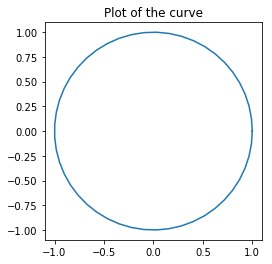

In [8]:
# Resolution for the parameter grid.
res = 50
t = np.linspace(0,2*np.pi,res)
circle = Curve(t, np.cos, np.sin)
circle.plot()

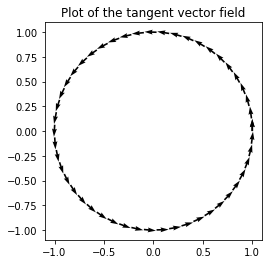

In [9]:
circle.tangent_plot()

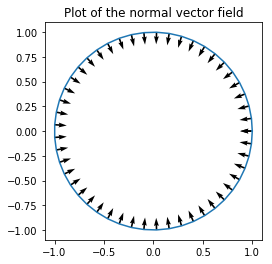

In [10]:
circle.normal_plot()

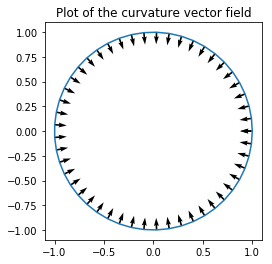

In [11]:
circle.curvature_plot()

In [12]:
plt.clf()
res = 100
t = np.linspace(0,2*np.pi,res)
circle = Curve(t, np.cos, np.sin)

iterations = 75

step_size = 0.005

anim = circle.animate_evolution(iterations, step_size, False)
HTML(anim.to_html5_video())

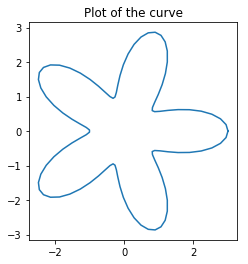

In [13]:
plt.clf()
petals = 5
res = 100
t = np.linspace(0,2*np.pi, res)

def flower_x(t):
    return (2+np.cos(petals*t))*np.cos(t)
def flower_y(t):
    return (2+np.cos(petals*t))*np.sin(t)

flower = Curve(t,flower_x,flower_y)
flower.plot()

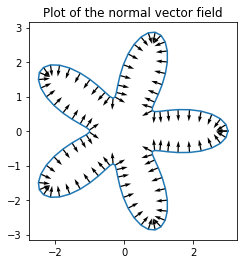

In [14]:
flower.normal_plot()

In [15]:
plt.clf()
iterations = 70
step_size = 0.006
smoothing = True
window_size = 2
anim = flower.animate_evolution(iterations, step_size, smoothing, window_size)
HTML(anim.to_html5_video())

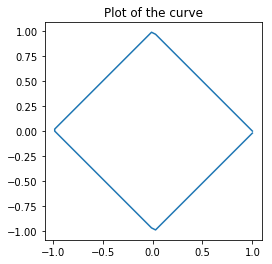

In [16]:
plt.clf()
res = 100
t = np.linspace(0,2*np.pi, res)

def square_x(t):
    return 2*np.abs(t-np.pi)/np.pi - 1
def square_y(t):
    f = np.zeros_like(t)
    f[t<np.pi] = 1 - np.abs(t[t<np.pi]-np.pi/2)/(np.pi/2)
    f[t>np.pi] = -f[t<np.pi]
    return f

square = Curve(t,square_x, square_y)
square.plot()

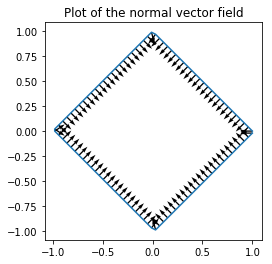

In [17]:
plt.clf()
square.normal_plot()

In [18]:
plt.clf()
iterations = 70
step_size = 0.001
smoothing = True
window_size=2
anim = square.animate_evolution(iterations, step_size, smoothing, window_size)
HTML(anim.to_html5_video())